In [22]:
cd /Users/yamadaikuya/gitrepos/tensor_flow/ImageRecognition/TowerRecognition/image

/Users/yamadaikuya/gitrepos/tensor_flow/ImageRecognition/image


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from PIL import Image
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.scroll_box { height:30em  !important; }</style>"))

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

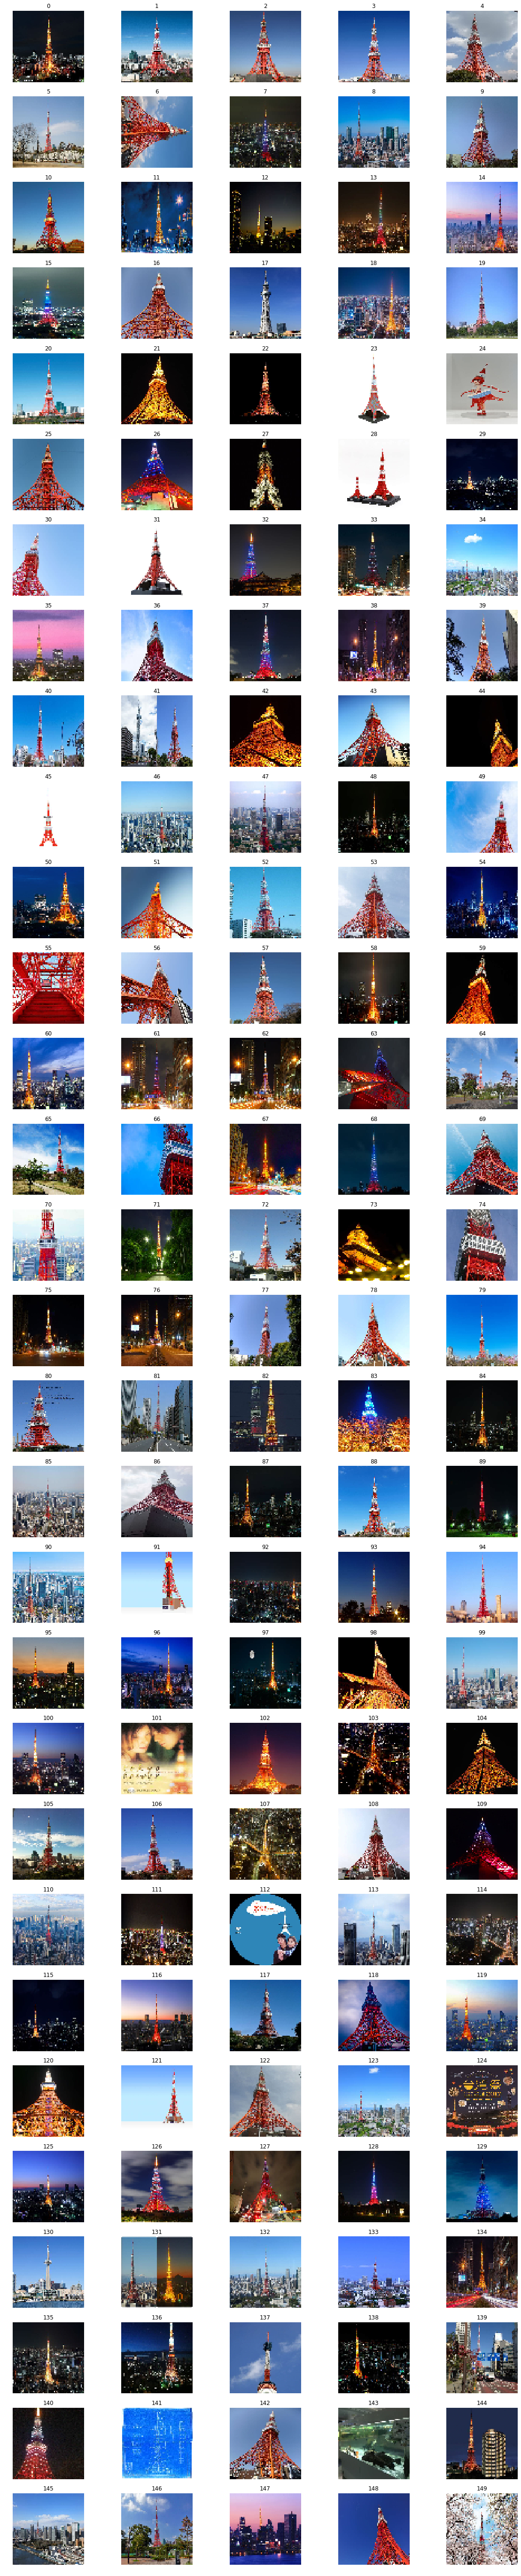

In [4]:
# Check the images
tokyotower = []
plt.figure(figsize=(20, 100))
for i in range(150):
    plt.subplot(30,5, i+1)
    im = Image.open("tokyotower/tokyotower" + str(i) + ".jpeg")
    im = im.resize((64, 64))
    im_list = np.asarray(im)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(im_list)
    tokyotower.append(im_list.reshape(-1, 1))
plt.show()
tokyotower = np.array(tokyotower)

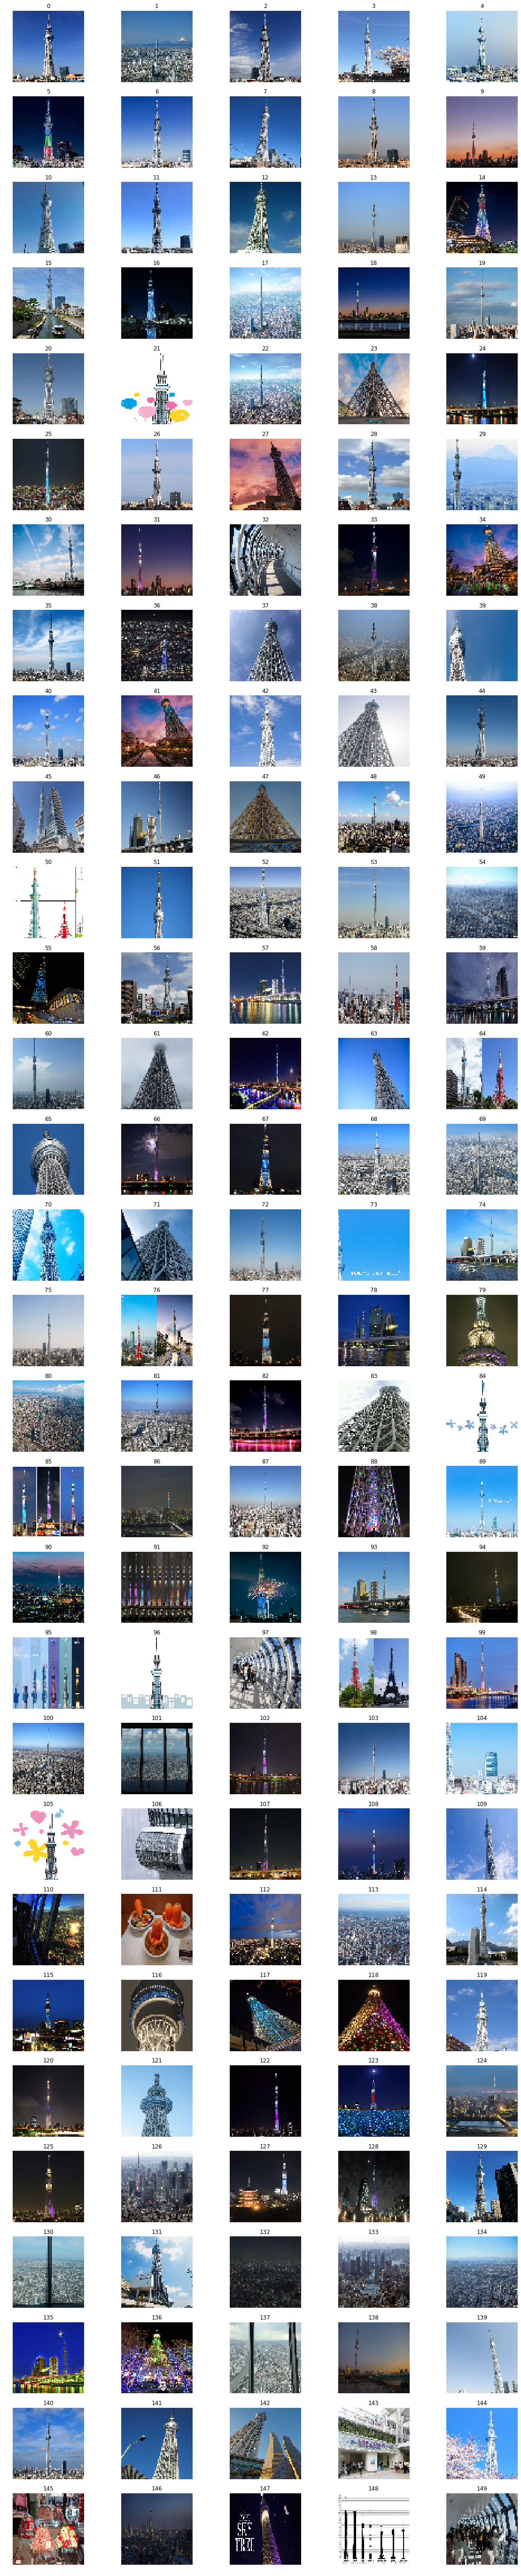

In [5]:
# Check the images
skytree = []
plt.figure(figsize=(20, 100))
for i in range(150):
    plt.subplot(30, 5, i+1)
    im = Image.open("skytree/skytree" + str(i) + ".jpeg")
    im = im.resize((64, 64))
    im_list = np.asarray(im)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(im_list)
    skytree.append(im_list.reshape(-1, 1))
plt.show()
skytree = np.array(skytree)

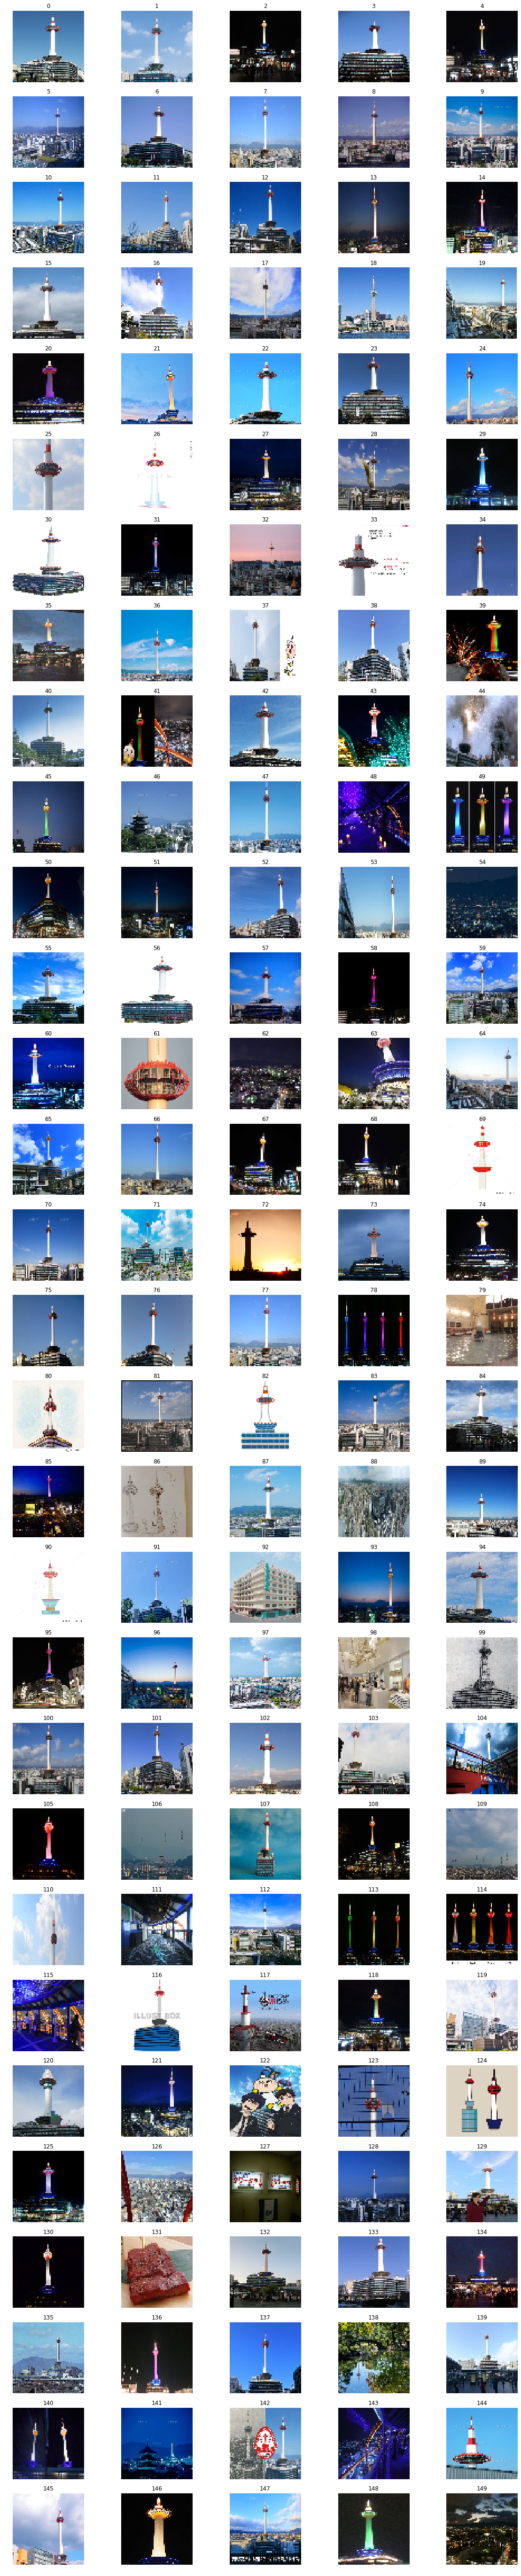

In [6]:
# Check the images
kyototower = []
plt.figure(figsize=(20, 100))
for i in range(150):
    plt.subplot(30, 5, i+1)
    im = Image.open("kyototower/kyototower" + str(i) + ".jpeg")
    im = im.resize((64, 64))
    im_list = np.asarray(im)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(im_list)
    kyototower.append(im_list.reshape(-1, 1))
plt.show()
kyototower = np.array(kyototower)

In [7]:
# flattening images
def reshape(X):
    X  = X.reshape(150, -1)
    X = X / 255
    return X

ttower = reshape(tokyotower)
stree = reshape(skytree)
ktower = reshape(kyototower)

In [8]:
# delete the irrelevant images
tokyotower_refined = np.delete(ttower, [17, 24, 41, 55, 101, 103, 107, 112, 114, 124, 130, 131, 141, 143,145], 0)
skytree_refined = np.delete(stree, [32, 54, 58, 64, 76, 85, 95 ,91, 97, 98, 101, 106, 110, 111, 113, 126, 133, 134, 137, 143, 145, 148,149], 0)
kyototower_refined = np.delete(ktower, [41, 44, 46, 48, 49, 54, 62, 78, 79, 88, 86, 92, 98, 99, 106, 109, 111, 113, 114, 115, 122, 126, 127, 131, 138, 143, 149], 0)
X = np.concatenate([tokyotower_refined, skytree_refined, kyototower_refined])
#X = np.concatenate([ttower, stree, ktower])
X = X.reshape(X.shape[0], X.shape[1])
X.shape

(385, 12288)

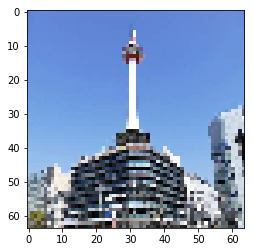

In [9]:
a = X[300].reshape(64, 64, 3)
a = (a*255).astype(int)
a
plt.imshow(a)

In [10]:
# tokyo = 0, skytree = 1, kyoto = 2
Y = np.zeros(len(tokyotower_refined) + len(skytree_refined) + len(kyototower_refined))
Y[:len(tokyotower_refined)] = 0
Y[len(tokyotower_refined): len(tokyotower_refined)+ len(skytree_refined)] = 1
Y[-len(kyototower_refined):] = 2

In [11]:
# creating Training set / Test set
def training(X, Y, seed=198, testsize=0.4):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=testsize, random_state=seed
    )
    return X_train.T, Y_train.T, X_test.T, Y_test.T

In [12]:
# n_x, n_y = nbr of variables
def create_placeholders(n_x, n_y):
    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None])
    return X, Y

In [13]:
def one_hot(labels, C):
    C = tf.constant(C, name="C")
    one_hot = tf.one_hot(labels, C, axis=0)
    sess = tf.Session()
    one_hot = sess.run(one_hot)
    sess.close()
    return one_hot

In [14]:
# initializing the parameters
def initialize_parameters():
    
    tf.set_random_seed(198)
    
    W1 = tf.get_variable("W1", [128, 64*64*3], initializer=tf.initializers.he_normal(seed=1))
    b1 = tf.get_variable("b1", [128, 1], initializer=tf.zeros_initializer())
    W_ = tf.get_variable("W_", [128, 128], initializer=tf.initializers.he_normal(seed=9))
    b_ = tf.get_variable("b_", [128, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [3, 128], initializer=tf.initializers.he_normal(seed=8))
    b2 = tf.get_variable("b2", [3, 1], initializer=tf.zeros_initializer())
    
    parameters={
        "W1": W1,
        "b1": b1,
        "W_": W_,
        "b_": b_,
        "W2": W2,
        "b2": b2
    }
    
    return parameters

In [15]:
def forward_propagation(X, parameters):
    # retrieve parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W_ = parameters['W_']
    b_ = parameters['b_']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)  
    Z_ = tf.add(tf.matmul(W_, A1), b_)
    A_ = tf.nn.relu(Z_)
    Z2 = tf.add(tf.matmul(W2, A_), b2)
    
    return Z2

In [16]:
def compute_cost(Z2, Y):
    logits = tf.transpose(Z2)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [17]:
# L2 reguralization
def l2(W1, W_, W2, lamda=0.01):
    return lamda*(tf.nn.l2_loss(W1) + tf.nn.l2_loss(W_) + tf.nn.l2_loss(W2))

In [23]:
# check the behavior
tf.reset_default_graph()
sess = tf.Session()
a, b = create_placeholders(64*64*3, 3)
parameters = initialize_parameters()
Z3 = forward_propagation(a, parameters)
cost = compute_cost(Z3, b)
print("Z2 = {}".format(str(Z3)))
print("cost = {}".format(str(cost)))

Z2 = Tensor("Add_2:0", shape=(3, ?), dtype=float32)
cost = Tensor("Mean:0", shape=(), dtype=float32)


In [24]:
# createing mini batches
import random
def create_minibatch(X, Y, batch_size, seed=198):
    random.seed(seed)
    X_batch = []
    Y_batch = []
    _ = [i for i in range(X.shape[1])]
    random.shuffle(_)
    X = X[:, _]
    Y = Y[:, _]
    num = X.shape[1] // batch_size
    for i in range(num):
        X_batch.append(X[:, i*num : i*num + batch_size])
        Y_batch.append(Y[:, i*num : i*num + batch_size])
    X_batch.append(X[:, num*batch_size : ])
    Y_batch.append(Y[:, num*batch_size : ])
    return X_batch, Y_batch, num+1

In [32]:
def model(X_train, Y_train, X_test, Y_test, num_epochs, learning_rate = 0.001, lamda=0.01,print_cost = True):
    ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables    
    tf.set_random_seed(18)
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []    
    costs_test = []
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    W1= parameters["W1"]
    W_ = parameters["W_"]
    #W__ = parameters["W__"]
    W2 = parameters["W2"]
    L2 = l2(W1, W_, W2, lamda=lamda)
    cost = compute_cost(Z3, Y)
    cost = cost + L2
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
     # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    flag = False
    epoch_seed=0
    for epoch in tqdm(range(num_epochs+1)):
        epoch_cost = 0
        x, y, n = create_minibatch(X_train, Y_train, batch_size=30, seed=epoch_seed)
        for i, k in zip(x, y):
            _, c = sess.run([optimizer, cost], feed_dict={X: i, Y: k})
            epoch_cost += c/n
        if epoch % 10 == 0:
            epoch_acc = 1 - (accuracy.eval({X: X_train, Y: Y_train}, session=sess))
            costs.append(epoch_acc)
            test_acc = 1 - (accuracy.eval({X: X_test, Y: Y_test}, session=sess))
            costs_test.append(test_acc)
        if epoch % 200==0 and print_cost==True:
            print("Accuracy after epoch %i: %f"%(epoch, 1-epoch_acc))
            print("Test Accuracy after epoch %i: %f"%(epoch, 1-test_acc))
        epoch_seed += 1      
        
    # plot the cost
    plt.plot(np.squeeze(costs), c="blue")
    plt.plot(np.squeeze(costs_test), c="orange")
    plt.ylim(0, 1)
    plt.ylabel('ratio of misclassification')
    plt.xlabel('epoches (per tens)')
    plt.title("Learning rate = {} \nlambda = {}".format(str(learning_rate), str(lamda)))
    plt.show()
    
    # lets save the parameters in a variable
    parameters = sess.run(parameters)
    print ("Parameters have been trained!")
    
    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}, session=sess))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}, session=sess))
    
    output = correct_prediction

    return parameters, output

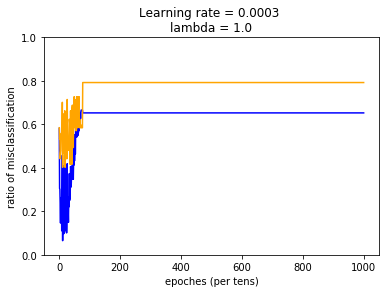

Parameters have been trained!
Train Accuracy: 0.3474026
Test Accuracy: 0.20779221


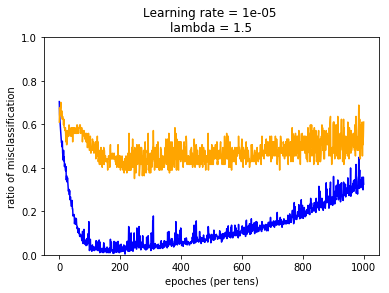

Parameters have been trained!
Train Accuracy: 0.6753247
Test Accuracy: 0.38961038


In [ ]:
X_train, Y_train, X_test, Y_test = training(X, Y, seed=864, testsize=0.2)
Y_train = one_hot(Y_train, 3)
Y_test = one_hot(Y_test, 3)
for i, k in zip([3e-4,1e-5, 5e-6], [1.0, 1.5, 2]):
    model(X_train, Y_train, X_test, Y_test, num_epochs=10000, learning_rate=i, lamda=k, print_cost=False)